# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_44', 'ORACLE.run1_32', 'ORACLE.run1_14', 'ORACLE.run1_8', 'ORACLE.run1_20', 'ORACLE.run1_50', 'ORACLE.run1_38', 'ORACLE.run1_26'}


{'ORACLE.run2_26', 'ORACLE.run2_44', 'ORACLE.run2_14', 'ORACLE.run2_32', 'ORACLE.run2_50', 'ORACLE.run2_20', 'ORACLE.run2_8', 'ORACLE.run2_38'}


tensor([[[-0.0013,  0.0068, -0.0012,  ..., -0.0069,  0.0031,  0.0037],
         [-0.0027,  0.0023,  0.0033,  ..., -0.0003, -0.0062, -0.0068]],

        [[ 0.0003,  0.0075, -0.0019,  ..., -0.0059, -0.0003, -0.0047],
         [-0.0026, -0.0019,  0.0040,  ...,  0.0021, -0.0082, -0.0054]],

        [[-0.0045, -0.0010,  0.0059,  ..., -0.0004, -0.0087,  0.0002],
         [-0.0027, -0.0060,  0.0040,  ...,  0.0053,  0.0020,  0.0089]],

        ...,

        [[ 0.0006,  0.0037, -0.0006,  ..., -0.0046, -0.0049, -0.0058],
         [-0.0050, -0.0015,  0.0073,  ...,  0.0005, -0.0057,  0.0046]],

        [[-0.0014,  0.0061,  0.0001,  ..., -0.0058,  0.0011,  0.0016],
         [-0.0027,  0.0002,  0.0035,  ...,  0.0014, -0.0059, -0.0058]],

        [[-0.0042, -0.0043,  0.0056,  ...,  0.0034, -0.0011,  0.0072],
         [ 0.0029, -0.0009, -0.0042,  ...,  0.0030,  0.0071,  0.0013]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.0076, train_label_loss: 2.8349, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2969.7885, train_label_loss: 0.4085, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2963.7494, train_label_loss: 0.5268, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2925.9515, train_label_loss: 0.8909, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2656.1717, train_label_loss: 0.5310, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2331.5030, train_label_loss: 0.3633, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2297.3980, train_label_loss: 0.3697, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2303.1823, train_label_loss: 0.2710, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2534.5054, train_label_loss: 0.2769, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2549.4742, train_label_loss: 0.1586, 


epoch: 1, source_val_acc_label: 0.6668, target_val_acc_label: 0.6806, source_val_label_loss: 122.8557, target_val_label_loss: 121.9855, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.0652, train_label_loss: 214.2908, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2323.4849, train_label_loss: 0.3093, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2575.2504, train_label_loss: 1.8583, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2608.6847, train_label_loss: 0.1642, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2704.9026, train_label_loss: 0.4955, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2575.9102, train_label_loss: 0.3284, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2565.3380, train_label_loss: 1.0646, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2776.9619, train_label_loss: 0.3331, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2963.9250, train_label_loss: 0.2466, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2932.7971, train_label_loss: 0.1791, 


epoch: 2, source_val_acc_label: 0.9051, target_val_acc_label: 0.9004, source_val_label_loss: 0.2747, target_val_label_loss: 0.3395, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.6743, train_label_loss: 0.5473, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2898.7286, train_label_loss: 0.0300, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3131.6342, train_label_loss: 0.1654, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3165.8775, train_label_loss: 0.5376, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3349.0691, train_label_loss: 0.2225, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3042.6866, train_label_loss: 0.0472, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3463.4233, train_label_loss: 0.1705, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3469.9849, train_label_loss: 0.2236, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3457.9048, train_label_loss: 0.1600, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3420.7163, train_label_loss: 0.2473, 


epoch: 3, source_val_acc_label: 0.9220, target_val_acc_label: 0.9160, source_val_label_loss: 0.2344, target_val_label_loss: 0.3023, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 3.3091, train_label_loss: 0.0639, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3320.0611, train_label_loss: 0.0924, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3546.7304, train_label_loss: 0.5554, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3560.2809, train_label_loss: 0.0896, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3030.0876, train_label_loss: 0.2816, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2652.8446, train_label_loss: 0.0456, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2571.9610, train_label_loss: 0.1056, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2589.1683, train_label_loss: 0.1730, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2590.8592, train_label_loss: 0.1309, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2667.5019, train_label_loss: 0.2826, 


epoch: 4, source_val_acc_label: 0.9349, target_val_acc_label: 0.9275, source_val_label_loss: 0.1909, target_val_label_loss: 0.2818, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.3142, train_label_loss: 0.1586, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3380.6871, train_label_loss: 0.4679, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3675.2098, train_label_loss: 0.3476, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3910.3837, train_label_loss: 0.2909, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3609.3071, train_label_loss: 0.0775, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2996.0067, train_label_loss: 0.2844, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3052.8042, train_label_loss: 0.0980, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2989.4232, train_label_loss: 0.1781, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2965.3830, train_label_loss: 0.0574, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3009.5677, train_label_loss: 0.2944, 


epoch: 5, source_val_acc_label: 0.9224, target_val_acc_label: 0.9077, source_val_label_loss: 0.2169, target_val_label_loss: 0.3133, 


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.7509, train_label_loss: 0.0731, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3428.3041, train_label_loss: 0.2528, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3740.0966, train_label_loss: 0.1619, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3876.9518, train_label_loss: 0.2509, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3450.9195, train_label_loss: 0.1531, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2978.1453, train_label_loss: 0.2784, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3010.9814, train_label_loss: 0.1260, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2990.6584, train_label_loss: 0.1250, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2733.4504, train_label_loss: 0.1302, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2316.1150, train_label_loss: 0.1629, 


epoch: 6, source_val_acc_label: 0.9324, target_val_acc_label: 0.9180, source_val_label_loss: 0.1873, target_val_label_loss: 0.2948, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.0070, train_label_loss: 0.1385, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2564.4195, train_label_loss: 0.1245, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2884.9695, train_label_loss: 0.1957, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2823.5171, train_label_loss: 0.0527, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2607.3721, train_label_loss: 0.0095, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2600.1969, train_label_loss: 0.0102, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2582.8220, train_label_loss: 0.1467, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2579.8093, train_label_loss: 0.1062, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2588.8386, train_label_loss: 0.0672, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2615.6042, train_label_loss: 0.0796, 


epoch: 7, source_val_acc_label: 0.9436, target_val_acc_label: 0.9299, source_val_label_loss: 0.1713, target_val_label_loss: 0.2959, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.2704, train_label_loss: 0.0862, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3396.4104, train_label_loss: 0.0811, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3579.6206, train_label_loss: 0.0996, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3048.7407, train_label_loss: 0.2267, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2938.4659, train_label_loss: 0.3590, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2940.6799, train_label_loss: 1.2906, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2916.8996, train_label_loss: 0.0795, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2991.9240, train_label_loss: 0.1432, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2977.4420, train_label_loss: 0.0851, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2942.1722, train_label_loss: 0.1080, 


epoch: 8, source_val_acc_label: 0.9478, target_val_acc_label: 0.9293, source_val_label_loss: 0.1523, target_val_label_loss: 0.2739, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.0840, train_label_loss: 0.2055, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2551.1671, train_label_loss: 0.1907, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2612.5446, train_label_loss: 0.3356, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2315.9173, train_label_loss: 0.2890, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2306.1239, train_label_loss: 0.2705, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2302.0272, train_label_loss: 0.3120, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2307.5648, train_label_loss: 0.0375, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2406.5514, train_label_loss: 0.1422, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2570.2137, train_label_loss: 0.0633, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2568.5377, train_label_loss: 0.1172, 


epoch: 9, source_val_acc_label: 0.9514, target_val_acc_label: 0.9346, source_val_label_loss: 0.1438, target_val_label_loss: 0.2721, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.0879, train_label_loss: 0.1422, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2583.7554, train_label_loss: 0.0546, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2596.4320, train_label_loss: 0.0166, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2608.2318, train_label_loss: 0.1633, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2579.1333, train_label_loss: 0.0075, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2610.9871, train_label_loss: 0.1522, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2598.2229, train_label_loss: 0.0974, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3056.9240, train_label_loss: 0.0934, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3234.7745, train_label_loss: 0.1327, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3451.2321, train_label_loss: 0.1523, 


epoch: 10, source_val_acc_label: 0.9489, target_val_acc_label: 0.9295, source_val_label_loss: 0.1458, target_val_label_loss: 0.2844, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 3.0501, train_label_loss: 0.0869, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3777.8072, train_label_loss: 0.1548, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3838.9652, train_label_loss: 0.1363, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2974.3765, train_label_loss: 0.1700, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2916.6234, train_label_loss: 0.0274, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2986.3789, train_label_loss: 0.2822, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2976.9756, train_label_loss: 0.2785, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3075.1763, train_label_loss: 0.0332, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3056.2675, train_label_loss: 0.0536, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2631.9591, train_label_loss: 0.2650, 


epoch: 11, source_val_acc_label: 0.9541, target_val_acc_label: 0.9352, source_val_label_loss: 0.1313, target_val_label_loss: 0.2570, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.0259, train_label_loss: 0.4183, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2310.1968, train_label_loss: 0.0358, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 2297.9933, train_label_loss: 0.1381, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2304.7346, train_label_loss: 0.5441, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2293.7333, train_label_loss: 0.1643, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2312.5415, train_label_loss: 0.0997, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2592.5659, train_label_loss: 0.0980, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2795.8428, train_label_loss: 0.1511, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2892.2177, train_label_loss: 0.1828, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2660.4154, train_label_loss: 0.0204, 


epoch: 12, source_val_acc_label: 0.9544, target_val_acc_label: 0.9328, source_val_label_loss: 0.1340, target_val_label_loss: 0.2654, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.0151, train_label_loss: 0.0891, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2319.9001, train_label_loss: 0.3133, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2316.3255, train_label_loss: 0.0546, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2325.4646, train_label_loss: 0.1649, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2297.0755, train_label_loss: 0.0176, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2370.2192, train_label_loss: 0.0191, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2590.0186, train_label_loss: 0.0998, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2827.2311, train_label_loss: 0.2387, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2904.9507, train_label_loss: 0.2130, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2710.0341, train_label_loss: 0.0228, 


epoch: 13, source_val_acc_label: 0.9573, target_val_acc_label: 0.9320, source_val_label_loss: 0.1250, target_val_label_loss: 0.2842, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.0087, train_label_loss: 0.1455, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 2327.6054, train_label_loss: 0.0130, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2320.7500, train_label_loss: 0.2940, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 2323.6329, train_label_loss: 0.1383, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 2291.7044, train_label_loss: 0.0356, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2400.8071, train_label_loss: 0.0828, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2626.7000, train_label_loss: 0.1864, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 2876.5017, train_label_loss: 0.0250, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2877.7496, train_label_loss: 0.1426, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2607.7322, train_label_loss: 0.0120, 


epoch: 14, source_val_acc_label: 0.9557, target_val_acc_label: 0.9346, source_val_label_loss: 0.1270, target_val_label_loss: 0.2731, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.2838, train_label_loss: 0.0680, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2651.5794, train_label_loss: 0.0607, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2898.8879, train_label_loss: 0.0891, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2925.3091, train_label_loss: 0.1817, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2912.5417, train_label_loss: 0.0572, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3053.7832, train_label_loss: 0.0391, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3686.9854, train_label_loss: 0.0366, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 4197.9574, train_label_loss: 0.0299, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3716.4712, train_label_loss: 0.0116, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 4014.5872, train_label_loss: 0.1451, 


epoch: 15, source_val_acc_label: 0.9577, target_val_acc_label: 0.9368, source_val_label_loss: 0.1238, target_val_label_loss: 0.2556, 


New best


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.8979, train_label_loss: 0.0307, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 2951.0724, train_label_loss: 0.0339, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 2360.5569, train_label_loss: 0.1925, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 2292.6735, train_label_loss: 0.0442, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 2305.3803, train_label_loss: 0.1173, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 2422.7999, train_label_loss: 0.0791, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 2641.2829, train_label_loss: 0.0429, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 2602.2423, train_label_loss: 0.1140, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 2456.1434, train_label_loss: 0.0102, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 2316.5680, train_label_loss: 0.0600, 


epoch: 16, source_val_acc_label: 0.9584, target_val_acc_label: 0.9345, source_val_label_loss: 0.1235, target_val_label_loss: 0.2764, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.0908, train_label_loss: 0.2182, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 2702.9688, train_label_loss: 0.0871, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 2351.1815, train_label_loss: 0.0573, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 2322.6926, train_label_loss: 0.0231, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2329.7168, train_label_loss: 0.1110, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2458.2302, train_label_loss: 0.2299, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2607.4386, train_label_loss: 0.0186, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2611.9060, train_label_loss: 0.0365, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2356.9843, train_label_loss: 0.1149, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 2339.8157, train_label_loss: 0.0091, 


epoch: 17, source_val_acc_label: 0.9516, target_val_acc_label: 0.9326, source_val_label_loss: 0.1408, target_val_label_loss: 0.2658, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 2.1211, train_label_loss: 0.0132, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 2699.7246, train_label_loss: 0.1018, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 2293.5107, train_label_loss: 0.0352, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 2308.6650, train_label_loss: 0.1643, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 2302.7528, train_label_loss: 0.2994, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 2496.8303, train_label_loss: 0.4127, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 2599.7574, train_label_loss: 0.0458, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 2696.0512, train_label_loss: 0.2880, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 2351.9030, train_label_loss: 0.1682, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 2310.3039, train_label_loss: 0.2344, 


epoch: 18, source_val_acc_label: 0.9569, target_val_acc_label: 0.9380, source_val_label_loss: 0.1268, target_val_label_loss: 0.2640, 


New best


epoch: 19, [batch: 1 / 6720], examples_per_second: 2.1338, train_label_loss: 0.0129, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 2768.5657, train_label_loss: 0.1334, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 2323.9712, train_label_loss: 0.0819, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 2326.6911, train_label_loss: 0.2240, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 2330.2255, train_label_loss: 0.0209, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 2546.7873, train_label_loss: 0.1623, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 2661.8897, train_label_loss: 0.0276, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 2676.3703, train_label_loss: 0.2830, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 2375.5520, train_label_loss: 0.0038, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 2365.3156, train_label_loss: 0.0502, 


epoch: 19, source_val_acc_label: 0.9518, target_val_acc_label: 0.9276, source_val_label_loss: 0.1403, target_val_label_loss: 0.2882, 


epoch: 20, [batch: 1 / 6720], examples_per_second: 2.4023, train_label_loss: 0.0197, 


epoch: 20, [batch: 672 / 6720], examples_per_second: 3008.5001, train_label_loss: 0.1287, 


epoch: 20, [batch: 1344 / 6720], examples_per_second: 2616.6644, train_label_loss: 0.0217, 


epoch: 20, [batch: 2016 / 6720], examples_per_second: 2625.2675, train_label_loss: 0.0322, 


epoch: 20, [batch: 2688 / 6720], examples_per_second: 2917.4011, train_label_loss: 0.0459, 


epoch: 20, [batch: 3360 / 6720], examples_per_second: 2807.1252, train_label_loss: 0.0146, 


epoch: 20, [batch: 4032 / 6720], examples_per_second: 2616.1708, train_label_loss: 0.0119, 


epoch: 20, [batch: 4704 / 6720], examples_per_second: 2609.3187, train_label_loss: 0.1109, 


epoch: 20, [batch: 5376 / 6720], examples_per_second: 2567.6881, train_label_loss: 0.0338, 


epoch: 20, [batch: 6048 / 6720], examples_per_second: 2684.7006, train_label_loss: 0.0969, 


epoch: 20, source_val_acc_label: 0.9613, target_val_acc_label: 0.9341, source_val_label_loss: 0.1148, target_val_label_loss: 0.2696, 


epoch: 21, [batch: 1 / 6720], examples_per_second: 2.4413, train_label_loss: 0.0323, 


epoch: 21, [batch: 672 / 6720], examples_per_second: 2999.1086, train_label_loss: 0.0050, 


epoch: 21, [batch: 1344 / 6720], examples_per_second: 2613.3229, train_label_loss: 0.3129, 


epoch: 21, [batch: 2016 / 6720], examples_per_second: 2573.6974, train_label_loss: 0.0330, 


epoch: 21, [batch: 2688 / 6720], examples_per_second: 2880.7738, train_label_loss: 0.1253, 


epoch: 21, [batch: 3360 / 6720], examples_per_second: 3037.5674, train_label_loss: 0.0776, 


epoch: 21, [batch: 4032 / 6720], examples_per_second: 2982.8557, train_label_loss: 0.2517, 


epoch: 21, [batch: 4704 / 6720], examples_per_second: 2995.6347, train_label_loss: 0.0629, 


epoch: 21, [batch: 5376 / 6720], examples_per_second: 3057.3557, train_label_loss: 0.0215, 


epoch: 21, [batch: 6048 / 6720], examples_per_second: 2961.6402, train_label_loss: 0.0975, 


epoch: 21, source_val_acc_label: 0.9592, target_val_acc_label: 0.9335, source_val_label_loss: 0.1240, target_val_label_loss: 0.2795, 


epoch: 22, [batch: 1 / 6720], examples_per_second: 2.2810, train_label_loss: 0.0540, 


epoch: 22, [batch: 672 / 6720], examples_per_second: 2646.3130, train_label_loss: 0.0687, 


epoch: 22, [batch: 1344 / 6720], examples_per_second: 2315.4404, train_label_loss: 0.0055, 


epoch: 22, [batch: 2016 / 6720], examples_per_second: 2305.4535, train_label_loss: 0.1806, 


epoch: 22, [batch: 2688 / 6720], examples_per_second: 2316.8249, train_label_loss: 0.1228, 


epoch: 22, [batch: 3360 / 6720], examples_per_second: 2320.0966, train_label_loss: 0.1066, 


epoch: 22, [batch: 4032 / 6720], examples_per_second: 2293.2067, train_label_loss: 0.0342, 


epoch: 22, [batch: 4704 / 6720], examples_per_second: 2308.7554, train_label_loss: 0.0071, 


epoch: 22, [batch: 5376 / 6720], examples_per_second: 2537.9610, train_label_loss: 0.0038, 


epoch: 22, [batch: 6048 / 6720], examples_per_second: 2562.7186, train_label_loss: 0.0250, 


epoch: 22, source_val_acc_label: 0.9619, target_val_acc_label: 0.9351, source_val_label_loss: 0.1195, target_val_label_loss: 0.2869, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

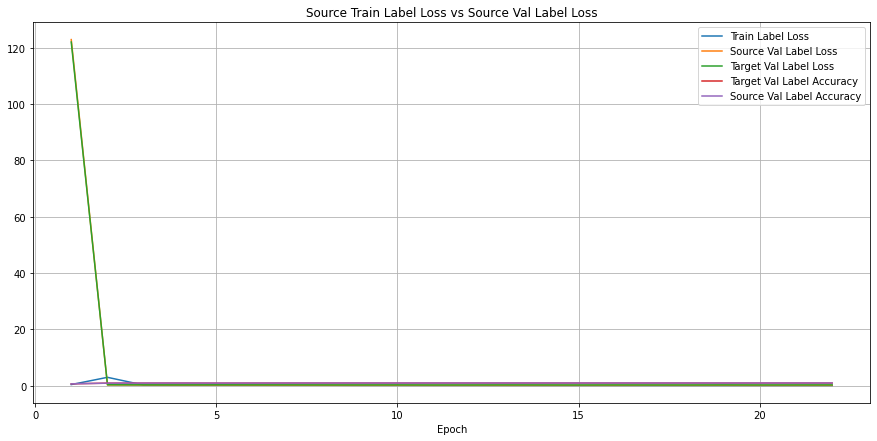

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

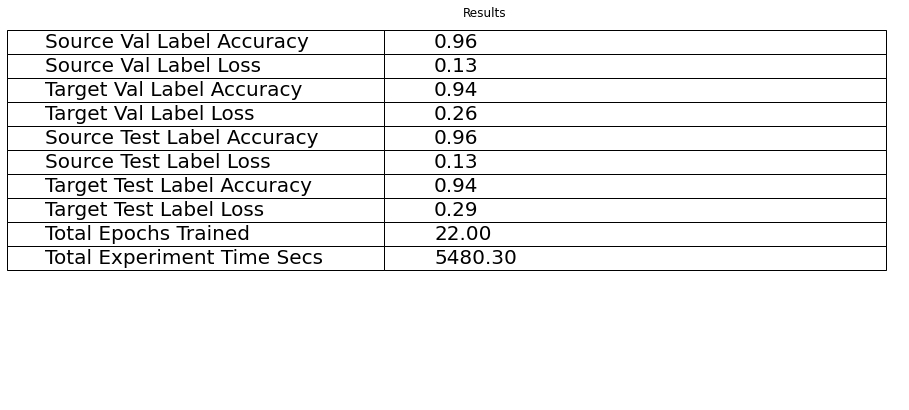

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

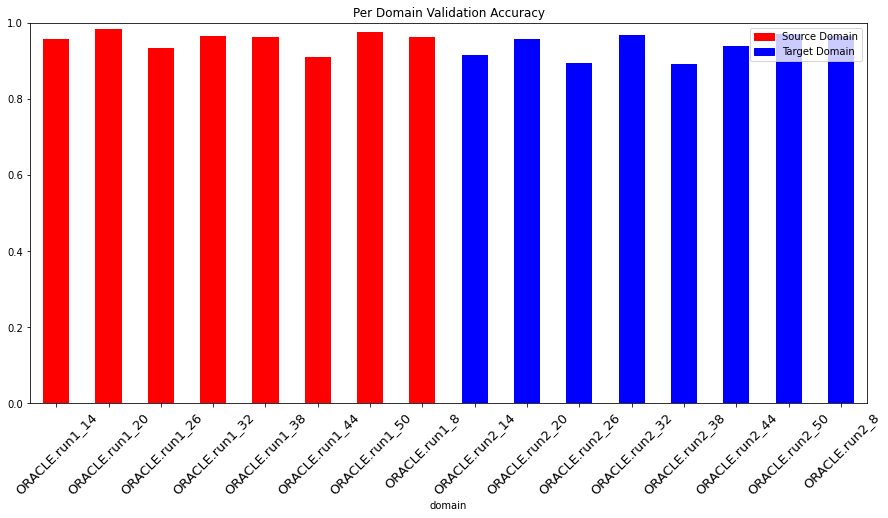

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9573893229166667 Target Test Label Accuracy: 0.9361328125
Source Val Label Accuracy: 0.9569010416666667 Target Val Label Accuracy: 0.93798828125


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048